In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import pickle

# EfficientNetV2B3, a 2021 CNN model, exhibits faster training speed and superior
# parameter efficiency compared to prior models, signifying a
# significant advancement in convolutional neural network architectures for computer vision tasks
from tensorflow.keras.applications import EfficientNetV2B3

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define tumor types
tumor_types = ['1no_tumor', 'glioma', 'meningioma', 'pituitary']

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Num GPUs Available:  1
Mounted at /content/drive


In [2]:
# Define directories
train_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Training'
val_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Validation'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=50,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=50,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

Found 8582 images belonging to 4 classes.
Found 829 images belonging to 4 classes.


In [3]:
# Define the model

base_model_efficientnet = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='max')

# Define your model
model = Sequential([
    base_model_efficientnet,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(4, activation='softmax')
])

print("")
model.summary()
print("")
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have train_generator and val_generator)

history = model.fit(train_generator, epochs=7, validation_data=val_generator, shuffle=False)

print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")

52606240/52606240 [==============================] - 1s 0us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                        

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


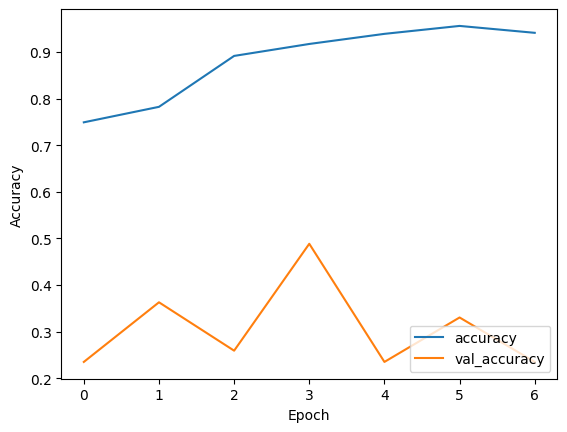

In [4]:
# Save the trained model
model_path = '/content/drive/MyDrive/CNN_MODEL1/EfficientnetV2B3/model_11/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save(os.path.join(model_path, 'model_multiclass.keras'))

# Save the training history
history_path = '/content/drive/MyDrive/CNN_MODEL1/EfficientnetV2B3/history_11/'
if not os.path.exists(history_path):
    os.makedirs(history_path)
training_metrics = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
}
with open(os.path.join(history_path, 'training_history_multiclass_11.pkl'), 'wb') as file:
    pickle.dump(training_metrics, file)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# # Prediction of the result

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

class ImageClassifier:
    def __init__(self, model_path):
        self.model = load_model(model_path)

    def preprocess_image(self, img_path):
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def classify_image(self, img_path):
        img_array = self.preprocess_image(img_path)
        predictions = self.model.predict(img_array)
        return predictions

    def plot_images_with_labels(self, image_folder):
        images = os.listdir(image_folder)
        num_images = len(images)

        fig, axes = plt.subplots(num_images, 2, figsize=(12, num_images * 4))

        for i, img_name in enumerate(images):
            img_path = os.path.join(image_folder, img_name)
            predictions = self.classify_image(img_path)
            original_image = image.load_img(img_path, target_size=(128, 128))

            axes[i, 0].imshow(original_image)
            axes[i, 0].axis('off')

            predicted_label = np.argmax(predictions[0])
            predicted_probability = predictions[0][predicted_label]
            tumor_types = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
            label_name = tumor_types[predicted_label]

            if label_name == 'glioma_tumor' or label_name == 'meningioma_tumor' or label_name == 'pituitary_tumor':
                label_assigned = 'Tumor Present'
            else:
                label_assigned = 'Tumor Not found'

            table_data = [['Prediction:', label_assigned], ['Probability:', f'{predicted_probability:.2f}']]
            axes[i, 1].axis('off')
            axes[i, 1].table(cellText=table_data, loc='center', colWidths=[0.5, 0.5])

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    model_path = "/content/drive/MyDrive/CNN_MODEL1/EfficientnetV2B3/model_11/model_multiclass.keras"

    # Initialize the classifier with the model
    classifier = ImageClassifier(model_path)

    # Set the image folder
    image_folder = "/content/drive/MyDrive/CNN_MODEL1/Testing_9"

    # Plot images with labels
    classifier.plot_images_with_labels(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 30ms/step
